In [2]:
import numpy as np
from scipy.signal import correlate2d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from os.path import isfile , join
from PIL import Image
import cv2

In [3]:
def rgb2gray(rgb_image):
        return np.dot(rgb_image[...,:3], [0.299, 0.587, 0.114])

# Template methods

In [4]:
from time import time

In [175]:
def match_template_corr( x , template , numPeaks = None, thresh = None):
    start_time = time()
    y = np.empty(x.shape)
    y = correlate2d(x,template,'same')
    end_time = time()
    comp_time_ms = end_time-start_time
    idx = find_peaks(y, template, numPeaks, thresh) #row then column
    return y, idx, comp_time_ms

In [186]:
def match_template_corr_zmean( x , template , numPeaks = None, thresh = None):
    y, idx, comp_time_ms = match_template_corr(x , template - template.mean(), numPeaks, thresh)
    return y, idx, comp_time_ms

In [15]:
def match_template_ssd( x , template , numPeaks = None, thresh = None):
    start_time = time()
    term1 = np.sum( np.square( template ))
    term2 = -2*correlate2d(x, template,'same')
    term3 = correlate2d( np.square( x ), np.ones(template.shape),'same' )
    ssd = np.maximum( term1 + term2 + term3 , 0 )
    y = 1 - np.sqrt(ssd)
    print(y)
    end_time = time()
    comp_time_ms = end_time-start_time
    idx = find_peaks(y, template, numPeaks, thresh) #row then column
    return y, idx, comp_time_ms

In [5]:
def match_template_xcorr( f , template , numPeaks = None, thresh = None):
    start_time = time()
    t = template
    f_c = f - correlate2d( f , np.ones(t.shape)/np.prod(t.shape), 'same') 
    t_c = t - t.mean()
    numerator = correlate2d( f_c , t_c , 'same' )
    d1 = correlate2d( np.square(f_c) , np.ones(t.shape), 'same')
    d2 = np.sum( np.square( t_c ))
    denumerator = np.sqrt( np.maximum( d1 * d2 , 0 )) # to avoid sqrt of negative
    response = np.zeros( f.shape )
    valid = denumerator > np.finfo(np.float32).eps # mask to avoid division by zero
    response[valid] = numerator[valid]/denumerator[valid]
    end_time = time()
    comp_time_ms = end_time-start_time
    idx = find_peaks(response, template, numPeaks, thresh) #row then column
    return response, idx, comp_time_ms

In [6]:
imgs_dir = 'templateImages'
imgs_names = ['cells.png','chess.jpg']
imgs_fnames = [ join( imgs_dir, img_name) for img_name in imgs_names ]
imgs_rgb = [ np.array(Image.open(img)) for img in imgs_fnames ]
imgs_gray = [ rgb2gray( img ) for img in imgs_rgb ]

temp_names = ['cellsTemplate.png','chessTemplate.jpg']
temp_fnames = [ join( imgs_dir, img_name) for img_name in temp_names ]
temp_rgb = [ np.array(Image.open(img)) for img in temp_fnames ]
templates = [ rgb2gray( img ) for img in temp_rgb ]


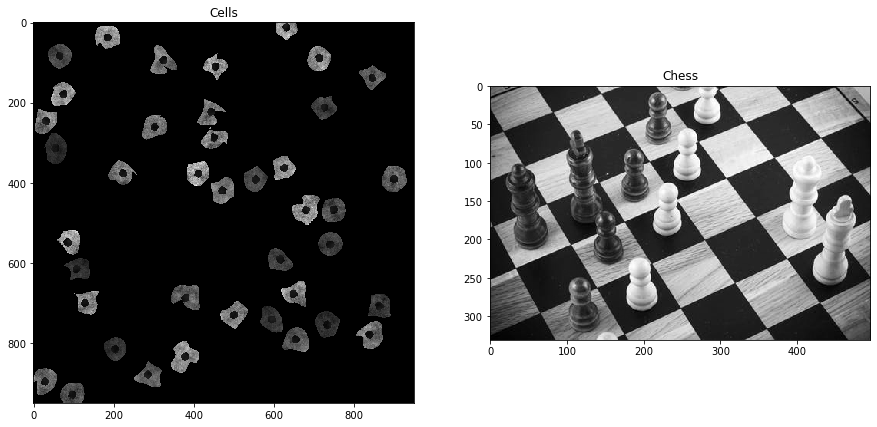

In [6]:
fig, ax = plt.subplots(1,2,figsize = (15, 10))
ax[1].set_title('Chess')
ax[0].imshow(imgs_gray[0], cmap = 'gray')
ax[0].set_title('Cells')
ax[1].imshow(imgs_gray[1], cmap = 'gray')

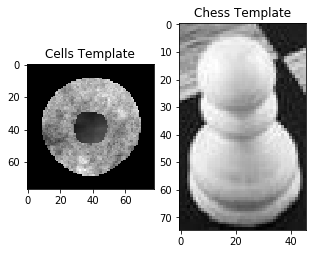

In [7]:
fig, ax = plt.subplots(1,2,figsize = (5, 5))
ax[1].set_title('Chess Template')
ax[0].imshow(templates[0], cmap = 'gray')
ax[0].set_title('Cells Template')
ax[1].imshow(templates[1], cmap = 'gray')

In [7]:
matches_corr0, idx, comp_time = match_template_xcorr(imgs_gray[0],templates[0], numPeaks = 5, thresh = None)

NameError: name 'find_peaks' is not defined

In [209]:
comp_time 

47.446959495544434

In [191]:
comp_time 

16.30727744102478

In [193]:
comp_time

16.243269681930542

In [195]:
comp_time

16.26128625869751

In [55]:
max_indices = np.where(matches_corr[0] == np.amax(matches_corr[0]))
p = max_indices[0][0]
q = max_indices[1][0]

In [57]:
matches_corr[0][p, q]

16973068.517919

# Find maximum

In [20]:
def find_peaks(matches, template, numPeaks = None, thresh = None):
    if numPeaks == None:
        numPeaks = 1
    if thresh == None:
        thresh = 0.5 * matches.max()
    nHoodSize = [template.shape[0],template.shape[1]] #height and width of template
    print(np.amax(matches))
    done = False
    row = []
    col = []
    newMatches = matches.copy()
    while not done:
        matches_max = np.amax(newMatches) 
        max_indices = np.where(newMatches == matches_max)
        p = max_indices[0][0]
        q = max_indices[1][0]
        if newMatches[p, q] >= thresh:
            row.append(p)
            col.append(q)
            p1 = int(p - (nHoodSize[0] - 1)/2 )
            p2 = int( p + (nHoodSize[0] - 1)/2)
            q1 = int(q - (nHoodSize[1] - 1)/2)
            q2 = int(q + (nHoodSize[1] - 1)/2)
            pp,qq = np.mgrid[p1:p2, q1:q2]
            pp = np.ravel(pp,'F')
            qq = np.ravel(qq,'F')
            gridCoordinates = list(zip(pp,qq))
            
            for i in range(len(gridCoordinates)):
                try:
                    newMatches[gridCoordinates[i]] = 0.0
                except IndexError:
                    pass
            done = (len(row) == numPeaks)
        else:
            done = True
    return list(zip(row, col))


In [19]:
idx

[]

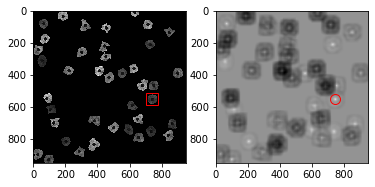

In [14]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(imgs_gray[0], cmap = 'gray')
ax[1].imshow(matches_corr0, cmap='gray')
htemp, wtemp = templates[0].shape
for f in range(len(idx)):
    # x is c and r is y
    r = idx[f][0]
    c = idx[f][1]
    if f == 0:
        rect = plt.Rectangle((c-wtemp/2, r-htemp/2), wtemp, htemp, edgecolor='r', facecolor='none')
        ax[1].plot(c, r, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
    else:
        rect =  plt.Rectangle((c-wtemp/2, r-htemp/2), wtemp, htemp, edgecolor='g', facecolor='none')
        ax[1].plot(c, r, 'o', markeredgecolor='g', markerfacecolor='none', markersize=10)
    ax[0].add_patch(rect)
    

    # ax.plot(r[0], c[0], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

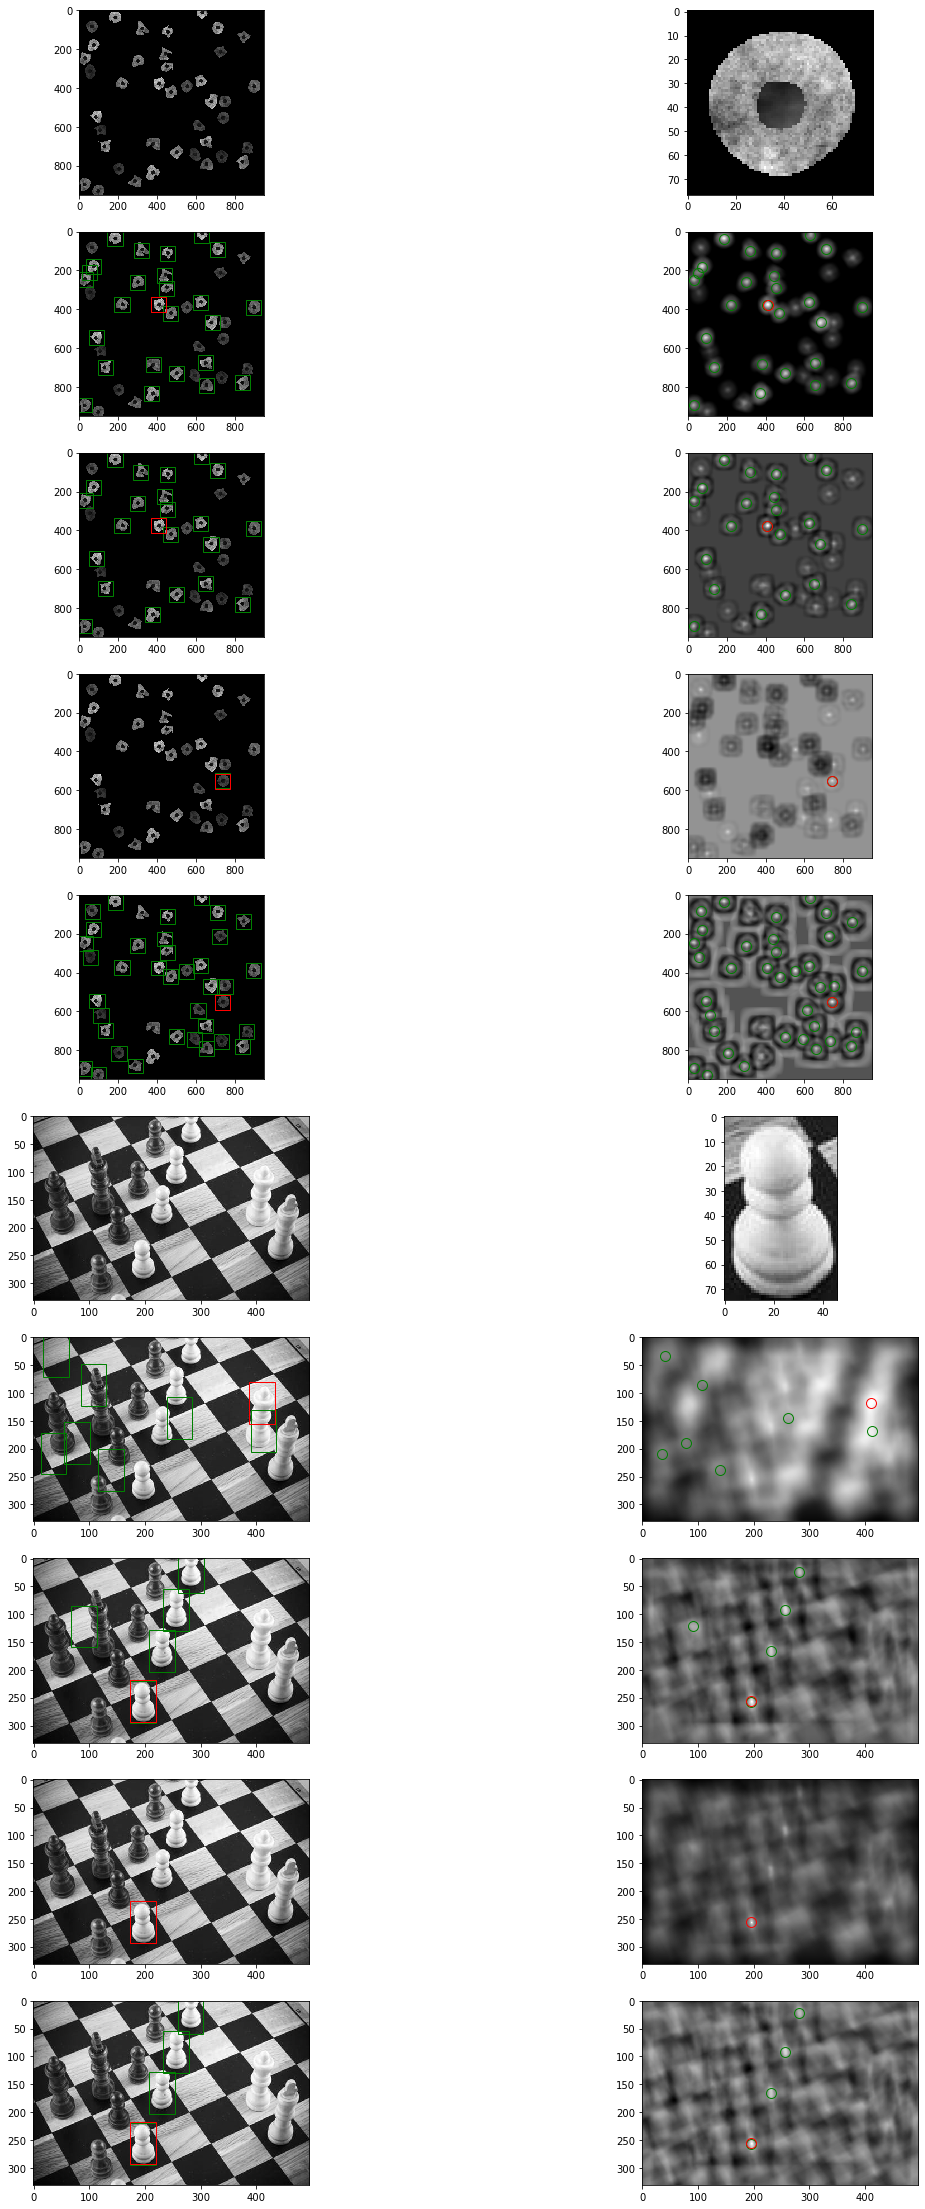

In [36]:
methods_n = 4
patches = zip(imgs_gray,templates,
              matches_corr,matches_corr_zmean,matches_ssd,matches_xcorr,
             matches_corr_peaks,matches_corr_zmean_peaks,matches_ssd_peaks,matches_xcorr_peaks)

fig, ax = plt.subplots(len(imgs_gray)*(methods_n+1),2,figsize = (20, 40))
plt.autoscale(True)
for i,(im,temp,mcorr,mcorrz,mssd,mxcorr,pcorr,pcorrz,pssd,pxcorr) in enumerate(patches):
    def get_rect_on_maximum(y,template):
        ij = np.unravel_index(np.argmax(y), y.shape)
        x, y = ij[::-1]
        # highlight matched region
        htemp, wtemp = template.shape
        rect = plt.Rectangle((x-wtemp/2, y-htemp/2), wtemp, htemp, edgecolor='r', facecolor='none')
        return rect,x,y
    
    def make_rects(plt_object,xy,template):
        htemp, wtemp = template.shape
        for ridx in range(xy.shape[0]):
            y,x = xy[ridx]
            r =  plt.Rectangle((x-wtemp/2, y-htemp/2), wtemp, htemp, edgecolor='g', facecolor='none')
            plt_object.add_patch(r)
    
    def make_circles(plt_object,xy,template):
        htemp, wtemp = template.shape
        for ridx in range(xy.shape[0]):
            y,x = xy[ridx]
            plt_object.plot(x, y, 'o', markeredgecolor='g', markerfacecolor='none', markersize=10)
            
    row = (methods_n+1)*i 
    ax[row,0].imshow(im, cmap = 'gray')
    ax[row,1].imshow(temp, cmap = 'gray')
    
    ax[row+ 1,0].imshow(im, cmap = 'gray')
    r,x,y = get_rect_on_maximum(mcorr,temp)
    make_rects( ax[row + 1,0] , pcorr, temp )
    ax[row + 1,0].add_patch(r)
    ax[row + 1,1].imshow(mcorr, cmap = 'gray')
    make_circles(ax[row + 1,1], pcorr,temp)
    ax[row + 1,1].plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
    
    r,x,y = get_rect_on_maximum(mcorrz,temp)
    ax[row + 2,0].imshow(im, cmap = 'gray')
    make_rects( ax[row + 2,0] , pcorrz, temp )
    ax[row + 2,0].add_patch(r)
    ax[row + 2,1].imshow(mcorrz, cmap = 'gray')
    make_circles(ax[row + 2,1], pcorrz,temp)
    ax[row + 2,1].plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

    
    r,x,y = get_rect_on_maximum(mssd,temp)
    ax[row + 3,0].imshow(im, cmap = 'gray')
    make_rects( ax[row + 3,0] , pssd, temp )
    ax[row + 3,0].add_patch(r)
    ax[row + 3,1].imshow(mssd, cmap = 'gray')
    make_circles(ax[row + 3,1], pssd,temp)
    ax[row + 3,1].plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
    
    r,x,y = get_rect_on_maximum(mxcorr,temp)
    ax[row + 4,0].imshow(im, cmap = 'gray')
    make_rects( ax[row + 4,0] , pxcorr, temp )
    ax[row + 4,0].add_patch(r)
    ax[row + 4,1].imshow(mxcorr, cmap = 'gray')
    make_circles(ax[row + 4,1], pxcorr,temp)
    ax[row + 4,1].plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

# GUI code trial

In [2]:
import CV404Template as temp

In [9]:
matches_corr0, idx, comp_time = temp.match_template_xcorr(imgs_gray[0],templates[0], numPeaks = 4, thresh = None)

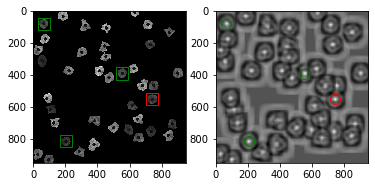

In [10]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(imgs_gray[0], cmap = 'gray')
ax[1].imshow(matches_corr0, cmap='gray')
htemp, wtemp = templates[0].shape
for f in range(len(idx)):
    # x is c and r is y
    r = idx[f][0]
    c = idx[f][1]
    if f == 0:
        rect = plt.Rectangle((c-wtemp/2, r-htemp/2), wtemp, htemp, edgecolor='r', facecolor='none')
        ax[1].plot(c, r, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
    else:
        rect =  plt.Rectangle((c-wtemp/2, r-htemp/2), wtemp, htemp, edgecolor='g', facecolor='none')
        ax[1].plot(c, r, 'o', markeredgecolor='g', markerfacecolor='none', markersize=10)
    ax[0].add_patch(rect)
    

In [15]:
templ0 = cv2.cvtColor(cv2.imread('templateImages/cellsTemplate.png',cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
img0 = cv2.cvtColor(cv2.imread('templateImages/cells.png',cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)

In [17]:
templ0 = rgb2gray(np.array(Image.open('templateImages/cellsTemplate.png')))
img0 = rgb2gray(np.array(Image.open('templateImages/cells.png')))

In [23]:
matches_corr0, idx, comp_time = temp.match_template_xcorr(img0,templ0, numPeaks = 4, thresh = None)

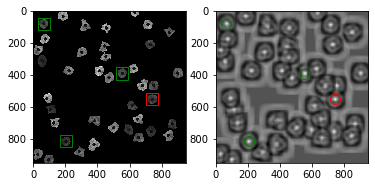

In [24]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(img0, cmap = 'gray')
ax[1].imshow(matches_corr0, cmap='gray')
htemp, wtemp = templates[0].shape
for f in range(len(idx)):
    # x is c and r is y
    r = idx[f][0]
    c = idx[f][1]
    if f == 0:
        rect = plt.Rectangle((c-wtemp/2, r-htemp/2), wtemp, htemp, edgecolor='r', facecolor='none')
        ax[1].plot(c, r, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
    else:
        rect =  plt.Rectangle((c-wtemp/2, r-htemp/2), wtemp, htemp, edgecolor='g', facecolor='none')
        ax[1].plot(c, r, 'o', markeredgecolor='g', markerfacecolor='none', markersize=10)
    ax[0].add_patch(rect)